# Импорт библиотек

In [16]:
import os
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import numpy as np
import re
import pandas as pd
from scipy.stats import norm
import pint
ureg = pint.UnitRegistry()

%load_ext line_profiler

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Константы

In [17]:
pi = np.pi
speed_of_light = c = 299792458.0 * ureg.meters / ureg.seconds
electron_mass = m_e = 9.1093837015e-31 * ureg.kilogram
eps0 = 8.854188e-12 * ureg.farad / ureg.m
q_e = 9.10938356e-31 * ureg.coulomb

# Входные данные

In [18]:
Q = -100e-9 * ureg.coulomb # Заряд пучка
N = 200  # Макрочастиц в пучке

pos_offsets = offset_x, offset_y, offset_z = 0.02 * ureg.m, 0.02 * ureg.m, 0 * ureg.m # Средние значения координат
pos_sigmas = sigma_x, sigma_y, sigma_z = 1e-4 * ureg.m, 1e-4 * ureg.m, 0.004 * ureg.m # Отклонения кординат

W, dW = 50 * ureg.megaelectron_volt, 1 * ureg.megaelectron_volt # Энергия и её разброс

eps_x, eps_y = 1e-9 * ureg.mm * ureg.millirad, 1e-9 * ureg.mm * ureg.millirad  # Эммитансы

# Генерация пучка

In [19]:
class Particle:
    __slots__ = ("q", "pos", "pulse", "W")
    
    def __init__(self, q, pos, pulse, W=None):
        self.q = q
        self.pos = pos
        self.pulse = pulse
        if W is None:
            self.W = (c * np.sqrt(np.sum(self.pulse**2) + (m_e * c)**2)).to("megaelectron_volt")
        else:
            self.W = W
            
    def recount_enegrgy(self):
        self.W = (c * np.sqrt(np.sum(self.pulse**2) + (m_e * c)**2)).to("megaelectron_volt")
        
    def __str__(self):
        res = (
            "<class Particle>\n"
            f"Координата: {self.pos}\n"
            f"Импульс: {self.pulse}\n"
            f"Энергия: {self.W}\n"
            f"Заряд: {self.q}\n"
        )
        return res
    
    def to_si(self):
        old_system = ureg.default_system
        ureg.default_system = "SI"
        
        res = Particle(
            self.q.to_base_units(),
            self.pos.to_base_units(), 
            self.pulse.to_base_units(),
            self.W.to_base_units()
        )
        
        ureg.default_system = old_system
        
        return res
    
    def to_dict(self, magnitude=False):
        res = {
            "q": self.q,
            "w": self.W,
            "x": self.pos[0],
            "y": self.pos[1],
            "z": self.pos[2],
            "px": self.pulse[0],
            "py": self.pulse[1],
            "pz": self.pulse[2],
        }
        
        if magnitude:
            for key in res:
                res[key] = res[key].magnitude
        
        return res
    
    def __repr__(self):
        return str(self)

In [20]:
def generate_particle():
    q = Q / N  # Заряд макрочастицы

    # Генерация координат
    x = np.random.normal(offset_x.to("m").magnitude, sigma_x.to("m").magnitude)
    y = np.random.normal(offset_y.to("m").magnitude, sigma_y.to("m").magnitude) 
    z = np.random.normal(0, sigma_z.to("m").magnitude) 

    pos = np.array([x, y, z]) * ureg.m
   
    # Генерация импульсов и энергии
    mean_pulse_z = p0z = np.sqrt((W / c)**2 - (m_e * c)**2)
    sigma_pz = np.sqrt(((W+dW) / c)**2 - (m_e * c)**2) - p0z 

    gamma = (W / (m_e * c**2)).to_base_units()
    sigma_px = (eps_x * 0.0001 / (gamma * sigma_x)).to_base_units()
    sigma_py = (eps_y * 0.0001 / (gamma * sigma_y)).to_base_units()

    px = (np.random.normal(0, sigma_px) * p0z).to_base_units()
    py = (np.random.normal(0, sigma_py) * p0z).to_base_units()
    pz = np.random.normal(p0z.to_base_units().magnitude, sigma_pz.to_base_units().magnitude) * p0z.to_base_units().units

    pulse = np.array([px.to_base_units().magnitude, py.to_base_units().magnitude, pz.to_base_units().magnitude]) * px.to_base_units().units

    return Particle(q, pos, pulse)

generate_particle()

D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


<class Particle>
Координата: [0.019898874095424655 0.02004396639167837 -0.0056194729101728055] meter
Импульс: [1.0371099040397387e-37 3.5536344878821393e-37 2.6792490878994044e-20] kilogram * meter / second
Энергия: 50.13557036034344 megaelectron_volt
Заряд: -4.999999999999999e-10 coulomb

In [21]:
bunch = np.array([generate_particle() for _ in range(50)])

D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
D:\Soft\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.


In [22]:
df = pd.DataFrame([x.to_si().to_dict(magnitude=True) for x in bunch])
df.head()

,q,w,x,y,z,px,py,pz
0,-5.000000e-10,8.023939e-12,0.019835,0.020044,0.005670,2.582960e-37,3.570436e-37,2.676359e-20
1,-5.000000e-10,7.888234e-12,0.019940,0.020051,-0.000891,-3.740938e-37,1.207584e-37,2.631090e-20
2,-5.000000e-10,7.968443e-12,0.019984,0.020085,-0.003275,4.424977e-37,1.060541e-37,2.657846e-20
3,-5.000000e-10,7.873815e-12,0.019891,0.020122,-0.003880,1.232459e-37,2.737183e-37,2.626280e-20
4,-5.000000e-10,7.860892e-12,0.020081,0.019963,-0.004104,3.181137e-37,-3.778369e-38,2.621969e-20


In [23]:
df.to_csv("console_particles_cpu/data.csv", sep=" ", index=False)

# Вычисление силы Кулона

In [100]:
def get_coulomb_force(p1, p2):
    gamma = (p1.W / (m_e * c**2))
  
    r0 = np.sqrt(p1.pos[0]**2 + p1.pos[1]**2)
    if p1.pos[1] >= 0:
        teta0 = np.arccos((p1.pos[0] / r0) if r0 != 0 else 0) # Angle from [0; pi]
    else:
        teta0 = 2*pi - np.arccos((p1.pos[0] / r0) if r0 != 0 else 0)
   
    r = np.sqrt(p2.pos[0]**2 + p2.pos[1]**2)
    if p2.pos[1] >= 0:
        teta = np.arccos((p2.pos[0] / r) if r != 0 else 0) # Angle from [0; pi]
    else:
        teta = 2*pi - np.arccos((p2.pos[0] / r) if r != 0 else 0)
    
    dteta_sin = np.sin(teta - teta0)
    dteta_cos = np.cos(teta - teta0)
    
    z_hat = ((p1.pos[2] - p2.pos[2]) * gamma)
    denominator = np.power((np.power(r, 2) + np.power(r0, 2) - 2*r*r0*dteta_cos + np.power(z_hat, 2)), 3/2)
    
    Q = (p1.q * p2.q)
    
    # Формулы вручную сокращены во избежание потери точности
    F_r = (Q * (r - r0 * dteta_cos)) / (gamma * denominator)
    F_teta = (Q * (r0 * dteta_sin)) / (gamma * denominator)
   
    teta_sin = np.sin(teta)
    teta_cos = np.cos(teta)

    K = 1 / (4 * pi * eps0)
    Fx = K * (F_r * teta_cos - F_teta * teta_sin)
    Fy = K * (F_r * teta_sin + F_teta * teta_cos)
    Fz = K * (Q * z_hat / denominator)
   
    return [Fx, Fy, Fz]

#%lprun -f get_coulomb_force get_coulomb_force(bunch[0], bunch[1])
[x.to_base_units() for x in get_coulomb_force(bunch[0], bunch[4])]

[-6.49495882937961e-05 <Unit('kilogram * meter / second ** 2')>,
 -6.49495882937961e-05 <Unit('kilogram * meter / second ** 2')>,
 0.0 <Unit('kilogram * meter / second ** 2')>]

# Динамика

In [101]:
# Частица действует сама на себя? Для черенковской силы?
# Поправка силы const ldouble abs_val = abs(q_e / data.bunches[s].p[0].q);
# Какая частица впереди?

dt = 1e-10 * ureg.sec
Rc = 2.5 * ureg.meter

In [102]:
init_q = 0.2 * ureg("nanocoulomb")
init_pulse = np.array([0, 0, 0]) * ureg("kg * m / s")
init_W = 100 * ureg.megaelectron_volt

bunch = [
    Particle(init_q, np.array([ 0.01,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01,  0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([-0.01, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.01, -0.01, 0]) * ureg.cm, init_pulse, init_W),
    Particle(init_q, np.array([ 0.00,  0.00, 0]) * ureg.cm, init_pulse, init_W),
]

In [103]:
bunch[4]

<class Particle>
Координата: [0.0 0.0 0.0] centimeter
Импульс: [0.0 0.0 0.0] kilogram * meter / second
Энергия: 100 megaelectron_volt
Заряд: 0.2 nanocoulomb

In [121]:
from collections import defaultdict
from tqdm.notebook import tqdm

forces = [[0 * ureg("dyne")] * 3 for _ in bunch]

for i in tqdm(range(len(bunch))):
    p1 = bunch[i]
    for j in range(i+1, len(bunch)):
        p2 = bunch[j]

        fx, fy, fz = [x.to("dyne") for x in get_coulomb_force(p1, p2)]
        #print((i+1, j+1), (fx.magnitude, fy.magnitude, fz.magnitude))

        forces[j][0] += fx
        forces[j][1] += fy
        forces[j][2] += fz

        forces[i][0] -= fx
        forces[i][1] -= fy
        forces[i][2] -= fz
            
for i, force in enumerate(forces):
    print(i+1, force)


1 [<Quantity(12.711328, 'dyne')>, <Quantity(12.711328, 'dyne')>, <Quantity(0.0, 'dyne')>]
2 [<Quantity(-12.711328, 'dyne')>, <Quantity(12.711328, 'dyne')>, <Quantity(0.0, 'dyne')>]
3 [<Quantity(-12.711328, 'dyne')>, <Quantity(-12.711328, 'dyne')>, <Quantity(0.0, 'dyne')>]
4 [<Quantity(12.711328, 'dyne')>, <Quantity(-12.711328, 'dyne')>, <Quantity(0.0, 'dyne')>]
5 [<Quantity(1.77635684e-15, 'dyne')>, <Quantity(-8.8817842e-16, 'dyne')>, <Quantity(0.0, 'dyne')>]


In [565]:
forces = get_forces()

for key in forces:
    print(key, [x.magnitude for x in forces[key]])

for i in tqdm(range(len(bunch))):
    bunch[i].pulse[0] += forces[i][0] * dt;
    bunch[i].pulse[1] += forces[i][1] * dt;
    bunch[i].pulse[2] += forces[i][2] * dt;
    
    bunch[i].recount_enegrgy()
    
    bunch[i].pos[0] += bunch[i].pulse[0] * (c**2 / bunch[i].W) * dt;
    bunch[i].pos[1] += bunch[i].pulse[1] * (c**2 / bunch[i].W) * dt;
    bunch[i].pos[2] += bunch[i].pulse[2] * (c**2 / bunch[i].W) * dt;


1 [22972339.442793768, -22972339.44279377, 6.206958912422761e-19]
2 [-22972339.442793775, -22972339.442793768, -3.4345050730530707e-19]
3 [-22972339.442793768, 22972339.44279377, -2.1104026056863106e-19]
0 [22972339.44279377, 22972339.442793764, -6.620512336833792e-20]


In [566]:
bunch[0].pulse[0] * (c**2 / bunch[0].W) * dt

3.3963786236856154e-15 <Unit('kilogram * meter ** 3 / megaelectron_volt / second ** 2')>

In [567]:
bunch[1]

<class Particle>
Координата: [1.0211985280000384 -1.0211985280000384 2.7683547115360526e-19] meter
Импульс: [0.002297233944279377 -0.0022972339442793774 3.000000006206959e-20] kilogram * meter / second
Энергия: 6.07897744318806e+18 megaelectron_volt
Заряд: 0.910938356 coulomb

# Визуализация

Text(0, 0.5, 'Energy, MeV')

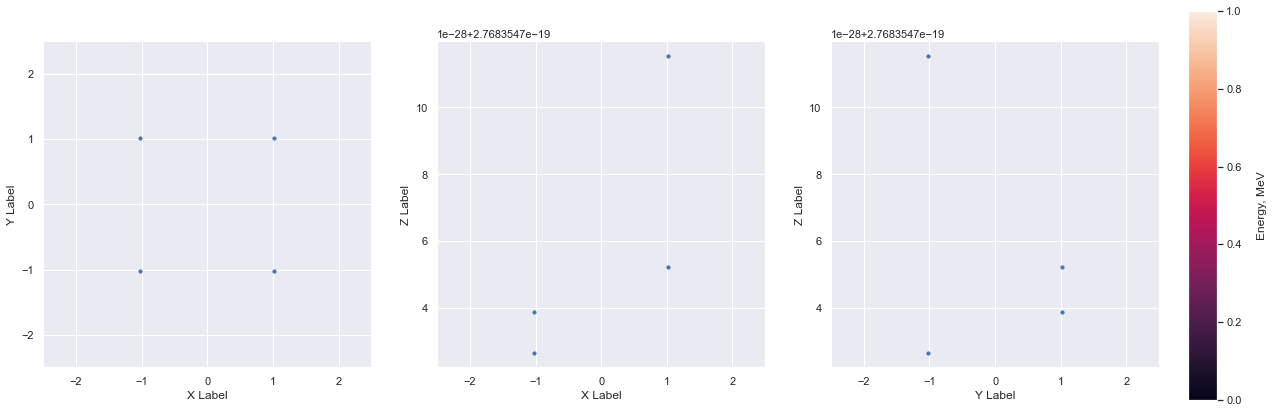

In [568]:
# Возможность зафиксировать границы волновода

poses = []
pulses = []
ws = []

for p in bunch:
    pos = [x.magnitude for x in p.pos]
    pulse = [x.magnitude for x in p.pulse]
    
    poses.append(pos)
    pulses.append(pulse)
    
    ws.append(p.W.magnitude)
    
poses = np.array(poses)
pulses = np.array(pulses)
ws = np.array(ws)


cmap = sns.cubehelix_palette(as_cmap=True)


xs, ys, zs = poses[:,0], poses[:,1], poses[:,2]

interval = (-Rc.magnitude, Rc.magnitude)

matplotlib.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20, 6))

ax = fig.add_subplot(131)
points = ax.scatter(xs, ys, s=10, cmap=cmap)
ax.set_xlabel('X Label'); ax.set_xlim(*interval);
ax.set_ylabel('Y Label'); ax.set_ylim(*interval)

ax = fig.add_subplot(132)
points = ax.scatter(xs, zs, s=10, cmap=cmap)
ax.set_xlabel('X Label'); ax.set_xlim(*interval)
ax.set_ylabel('Z Label')

ax = fig.add_subplot(133)
points = ax.scatter(ys, zs, s=10, cmap=cmap)
ax.set_xlabel('Y Label'); ax.set_xlim(*interval)
ax.set_ylabel('Z Label')

ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
cbar = plt.colorbar(points, cax=ax)

ax.set_ylabel('Energy, MeV', labelpad=15)

In [569]:
bunch[0]

<class Particle>
Координата: [1.0211985280000384 1.0211985280000384 2.7683547052174337e-19] meter
Импульс: [0.0022972339442793774 0.0022972339442793766 2.999999999337949e-20] kilogram * meter / second
Энергия: 6.07897744318806e+18 megaelectron_volt
Заряд: 0.910938356 coulomb